<a href="https://colab.research.google.com/github/papapabi/torch-sandbox/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Customer Churn Prediction

Customer churn, also known as customer attrition, refers to the rate at which customers stop doing business with a company. It's a key metric for businesses, especially those with subscription-based or recurring revenue models such as the ones found in the telecommunications industry. Understanding and reducing churn is crucial for maintaining a healthy customer base and ensuring long-term business success.

In the fiercely competitive telecom market, customers have many providers to choose from and frequently switch between them. This results in an annual customer turnover (churn) rate of 15% to 25%.

## Objective

Predict if a customer will churn or not based from the features provided in the dataset (binary classification).

## Telco Customer Churn - Kaggle

Each row represents a customer, each column contains that customer's attributes described on the column metadata.

The data set includes information about:

* **Customers who left within the last month** – the column is called Churn
* **Services that each customer has signed up for** – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* **Customer account information** – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* **Demographic info about customers** – gender, age range, and if they have partners and dependents

https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data

## Exploratory data analysis (EDA)

Dataset details:

* 7043 total instances
    * 7032 after removing 11 rows (see below, under types)
* 20 (1 feature can be safely dropped) features and 1 target variable `Churn`
    * the target variable `Churn` is not balanced, and therefore during splitting, we need to perform stratified sampling to preserve the class ratios for train/val/test sets
* dtypes and misc.
    * `customerID` can be safely dropped
    * `tenure` is an int representing the number of months this customer has subscribed
        * is it meaningful for `tenure` to be 0? Needs clarification from dataset source; else will be dropped. Rows with `tenure==0` also have `NaN`s in the `TotalCharges` column.
        * Assumption: `tenure=0` means customers who have subscribed initially but not lasted for a month. But their `Churn` column says `No`, so it's confusing.
        * Verdict: Will drop rows where `tenure==0` as they are confusing, and there are only 11 of them which is a very small percentage of the total data.
    * `MonthlyCharges` and `TotalCharges` are floats, and are in USD ($)
        * `TotalCharges` is initially in an object dtype, which may indicate some missing values; needs to be coerced into float
        * `TotalCharges` is positive/right-skewed, which may need a transformation like log transform to reduce skewness before scaling
    * `SeniorCitizen`, `Partner`, `Dependents`, `PhoneService`, `PaperlessBilling`, and `Churn` (target) are boolean columns
    * `gender`, `MultipleLines`, `InternetSecurity`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `Contract`, `PaymentMethod` are all categorical values that are not ordinal

Insights (incomplete):

* Customers with higher monthly charges seem to be more likely to churn.
* Customers with dependents are more likely to churn than those who do not have dependents. (31.2% vs 15.5%)
* Around 41.6% of senior citizens churn, compared to 23.6% for non-seniors.
* Gender seems to have no effect when it comes to churn.
* Around 42.7% of customers who are in a month-to-month contract churned compared to customers with one-year or two-year contracts. Only 11.2% of those who have 1-year contracts churn, and only 2.8% of those who have 2-year contracts churn.
* Customers without partners seem to be more likely to churn. (32.9% vs 19.7%)

In [1]:
!pip install altair

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

alt.renderers.enable("html")
pd.options.display.max_columns = None

In [3]:
filename = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(filename)

In [4]:
df.shape

(7043, 21)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [7]:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values in column '{column}':")
    print(unique_values)
    print()

Unique values in column 'customerID':
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Unique values in column 'gender':
['Female' 'Male']

Unique values in column 'SeniorCitizen':
[0 1]

Unique values in column 'Partner':
['Yes' 'No']

Unique values in column 'Dependents':
['No' 'Yes']

Unique values in column 'tenure':
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

Unique values in column 'PhoneService':
['No' 'Yes']

Unique values in column 'MultipleLines':
['No phone service' 'No' 'Yes']

Unique values in column 'InternetService':
['DSL' 'Fiber optic' 'No']

Unique values in column 'OnlineSecurity':
['No' 'Yes' 'No internet service']

Unique values in column 'OnlineBackup':
['Yes' 'No' 'No internet service']

Unique values in column 'DeviceProtection':
['No' 'Yes' 'No in

In [8]:
## Check for missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [9]:
# view rows with missing values in TotalCharges
df[np.isnan(df['TotalCharges'])]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [10]:
df[df['tenure'] == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


The above rows are equivalent, and we can drop them since they are confusing. All of them have a tenure of 0, TotalCharge of NaN, and a Churn of 'No'.

In [11]:
df = df.drop(labels=df[df['tenure'] == 0].index)

In [12]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [13]:
## Check descriptive stats for the numerical columns
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


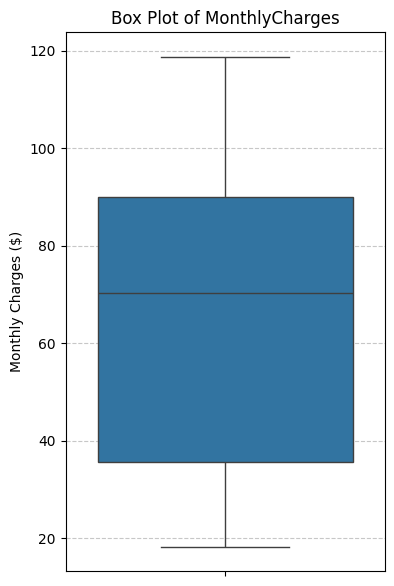

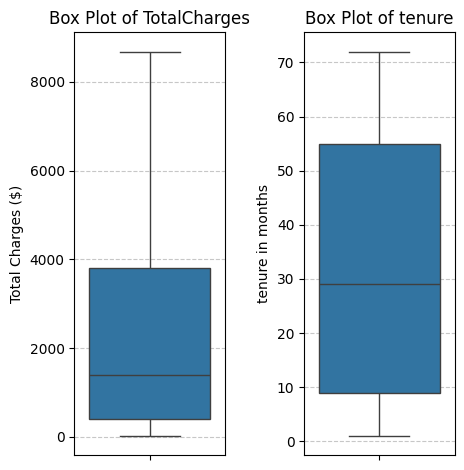

In [14]:
plt.figure(figsize=(14, 7))

# Monthly charges
plt.subplot(1, 3, 1)
sns.boxplot(y=df['MonthlyCharges'])
plt.title('Box Plot of MonthlyCharges')
plt.ylabel('Monthly Charges ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Total charges
plt.subplot(1, 3, 2)
sns.boxplot(y=df['TotalCharges'])
plt.title('Box Plot of TotalCharges')
plt.ylabel('Total Charges ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tenure
plt.subplot(1, 3, 3)
sns.boxplot(y=df['tenure'])
plt.title('Box Plot of tenure')
plt.ylabel('tenure in months')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

The distribution of 'TotalCharges' according to the box plot seems to be right-skewed. A transformation (such as log transformation) needs to be performed to reduce the skewness prior to scaling.

In [15]:
df['Churn'].value_counts()

,count
Churn,
No,5163
Yes,1869


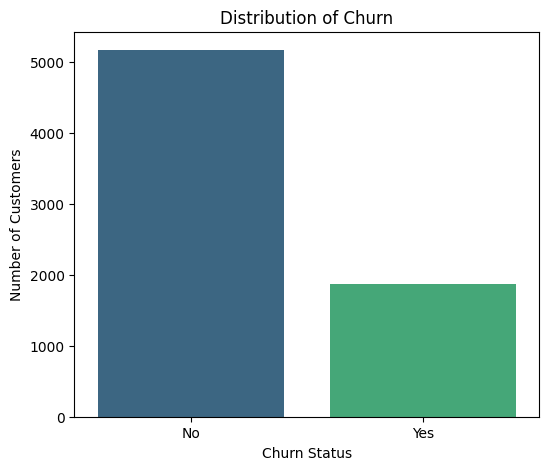

In [16]:
plt.figure(figsize=(6, 5))
sns.countplot(x='Churn', data=df, palette='viridis', hue='Churn', legend=False)
plt.title('Distribution of Churn')
plt.xlabel('Churn Status')
plt.ylabel('Number of Customers')
plt.show()

The target variable is imbalanced, and we need to keep that in mind when we form our train/val/test splits.

### Churn with respect to some of the independent variables / features


####  Distribution of monthly charges by churn status

Text(0, 0.5, 'Density')

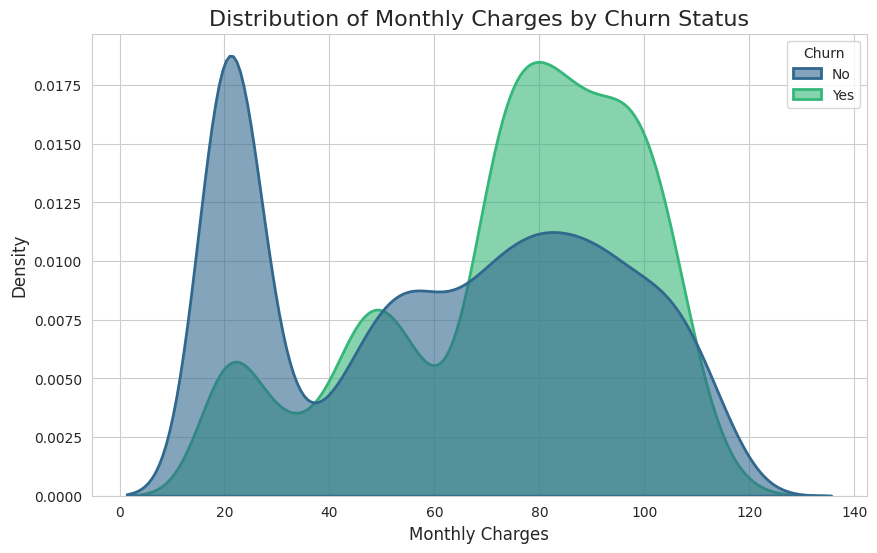

In [17]:
sns.set_style("whitegrid")

# Create the distribution plot (KDE plot is good for showing distributions)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True, common_norm=False, palette='viridis', alpha=0.6, linewidth=2)

plt.title('Distribution of Monthly Charges by Churn Status', fontsize=16)
plt.xlabel('Monthly Charges', fontsize=12)
plt.ylabel('Density', fontsize=12)
#plt.legend(title='Churn', labels=['Churn', 'No Churn'])

Customers with higher monthly charges seem to be more likely to churn.

#### Churn vs. dependents

In [18]:
churn_by_dependents = df.groupby(['Dependents', 'Churn']).size().reset_index(name='count')
churn_by_dependents

,Dependents,Churn,count
0,No,No,3390
1,No,Yes,1543
2,Yes,No,1773
3,Yes,Yes,326


In [19]:
chart = alt.Chart(churn_by_dependents).mark_bar().encode(
    x=alt.X('Dependents', axis=alt.Axis(title='Dependents')),
    y=alt.Y('count', axis=alt.Axis(title='Number of Customers')),
    color=alt.Color('Churn', title='Churn Status'),
    tooltip=['Dependents', 'Churn', 'count']
).properties(
    title='Customer Churn by Dependents'
).interactive()

In [20]:
chart

alt.Chart(...)

Customers with dependents are more likely to churn than those who do not have dependents. (31.2% vs 15.5%)

#### Churn vs. seniority

In [21]:
churn_by_seniority = df.groupby(['SeniorCitizen', 'Churn']).size().reset_index(name='count')
churn_by_seniority

,SeniorCitizen,Churn,count
0,0,No,4497
1,0,Yes,1393
2,1,No,666
3,1,Yes,476


In [22]:
chart = alt.Chart(churn_by_seniority).mark_bar().encode(
    x=alt.X('SeniorCitizen:N', # specify as Nominal (Categorical)
            axis=alt.Axis(title='SeniorCitizen')),
    y=alt.Y('count', axis=alt.Axis(title='Number of Customers')),
    color=alt.Color('Churn', title='Churn Status'),
    tooltip=['SeniorCitizen', 'Churn', 'count']
).properties(
    title='Customer Churn by Seniority'
).interactive()

In [23]:
chart

alt.Chart(...)

Around 41.6% of senior citizens churn, compared to 23.6% for non-seniors.

#### Churn vs. gender

In [24]:
churn_by_gender = df.groupby(['gender', 'Churn']).size().reset_index(name='count')
churn_by_gender

,gender,Churn,count
0,Female,No,2544
1,Female,Yes,939
2,Male,No,2619
3,Male,Yes,930


In [25]:
# Create a grouped bar chart
chart = alt.Chart(churn_by_gender).mark_bar().encode(
    x=alt.X('gender', axis=alt.Axis(title='Gender')),
    y=alt.Y('count', axis=alt.Axis(title='Number of Customers')),
    color=alt.Color('Churn', title='Churn Status'),
    tooltip=['gender', 'Churn', 'count']
).properties(
    title='Customer Churn by Gender'
).interactive()

In [26]:
chart

alt.Chart(...)

Gender seems to have no effect when it comes to churn.

#### Churn vs. contract type

In [27]:
# Calculate churn counts with respect to contract type
contract_churn_counts = df.groupby(['Contract', 'Churn']).size().reset_index(name='count')
contract_churn_counts

,Contract,Churn,count
0,Month-to-month,No,2220
1,Month-to-month,Yes,1655
2,One year,No,1306
3,One year,Yes,166
4,Two year,No,1637
5,Two year,Yes,48


In [28]:
chart = alt.Chart(contract_churn_counts).mark_bar().encode(
    x=alt.X('Contract', axis=alt.Axis(title='Contract Type')),
    y=alt.Y('count', axis=alt.Axis(title='Number of Customers')),
    color=alt.Color('Churn', title='Churn Status'),
    tooltip=['Contract', 'Churn', 'count']
).properties(
    title='Churn Distribution by Contract Type'
)

In [29]:
chart

alt.Chart(...)

According to the data, around 42.7% of customers who are in a month-to-month contract churned compared to customers with one-year or two-year contracts. Only 11.2% of those who have 1-year contracts churn, and only 2.8% of those who have 2-year contracts churn.

#### Churn vs. relationship status

In [30]:
# Calculate churn counts with respect to relationship status
partner_churn_counts = df.groupby(['Partner', 'Churn']).size().reset_index(name='count')
partner_churn_counts

,Partner,Churn,count
0,No,No,2439
1,No,Yes,1200
2,Yes,No,2724
3,Yes,Yes,669


In [31]:
chart = alt.Chart(partner_churn_counts).mark_bar().encode(
    x=alt.X('Partner', axis=alt.Axis(title='Relationship Status')),
    y=alt.Y('count', axis=alt.Axis(title='Number of Customers')),
    color=alt.Color('Churn', title='Churn Status'),
    tooltip=['Partner', 'Churn', 'count']
).properties(
    title='Churn Distribution by relationship status'
)

In [32]:
chart

alt.Chart(...)

Customers without partners seem to be more likely to churn. (32.9% vs 19.7%)

## Data preprocessing

In [59]:
df = pd.read_csv(filename)

### Drop ID column

In [60]:
df = df.drop('customerID', axis=1)
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Remove missing values from dataframe

In [61]:
df = df.drop(labels=df[df['tenure'] == 0].index)

In [62]:
df.isnull().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


### Coerce `TotalCharges` into a float dtype



In [63]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 
 17  

### Encode all categorical columns via `sklearn.preprocessing.LabelEncoder`

Only `tenure`, `MonthlyCharges`, and `TotalCharges` are numeric. The rest are categorical labels that need to be encoded into integers in the range [0, 1, ..., N-1], where N is the max number of categories in that column.

We would also need to save the `sklearn.preprocessing.LabelEncoder`instances to use them for inference later.

In [65]:
import pickle

from sklearn.preprocessing import LabelEncoder

numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_cols = [col for col in df.columns if col not in numeric_cols]

# goal: have le encoders accessed by the name of the column in question
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define the path where the encoders will be saved
encoders_filename = 'label_encoders.pkl'

# Save the dictionary of fitted LabelEncoders to a file using pickle.
# This allows you to load and reuse these encoders later for new data inference.
with open(encoders_filename, 'wb') as f:
    pickle.dump(label_encoders, f)

print(f"Fitted LabelEncoders saved to {encoders_filename}")

Fitted LabelEncoders saved to label_encoders.pkl


In [66]:
# Example of how to load and use the saved encoders for new data:
# if os.path.exists(encoders_filename):
#     with open(encoders_filename, 'rb') as f:
#         loaded_encoders = pickle.load(f)
#     print(f"\nLoaded encoders: {list(loaded_encoders.keys())}")
#
#     # To transform new data, you would do:
#     # new_data = pd.DataFrame({'Gender': ['Male'], 'Partner': ['Yes'], ...})
#     # for col, encoder in loaded_encoders.items():
#     #     if col in new_data.columns:
#     #         new_data[col] = encoder.transform(new_data[col])
#     # print(new_data.head())

In [67]:
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


### Transform the `TotalCharges` column values via log transform

Since the `TotalCharges` column is highly skewed, we need to transform it

In [68]:
import numpy as np

df['TotalCharges'] = np.log1p(df['TotalCharges']) # log(x+1) if there are any zeros in TotalCharges, safer for inference too
# df['TotalCharges'] = np.log1p(df['TotalCharges'])

In [70]:
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,3.429137,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,7.544597,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,4.692723,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,7.518471,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,5.028148,1


### Standardize all numerical columns with `sklearn.preprocessing.StandardScaler`

In [71]:
from sklearn.preprocessing import StandardScaler

numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

scalers = {}

for col in numerical_cols:
    scaler = StandardScaler()
    # Reshape the column to a 2D array, as StandardScaler expects a 2D array
    df[col] = scaler.fit_transform(df[[col]])
    # Store the fitted StandardScaler in the dictionary
    scalers[col] = scaler

scalers_filename = 'standard_scalers.pkl'

# Save the dictionary of fitted StandardScalers to a file using pickle.
# This allows you to load and reuse these scalers later for new data inference.
with open(scalers_filename, 'wb') as f:
    pickle.dump(scalers, f)

print(f"Fitted StandardScaler objects saved to '{scalers_filename}'.")

Fitted StandardScaler objects saved to 'standard_scalers.pkl'.


In [72]:
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,-1.280248,0,1,0,0,2,0,0,0,0,0,1,2,-1.161694,-2.272642,0
1,1,0,0,0,0.064303,1,0,0,2,0,2,0,0,0,1,0,3,-0.260878,0.388798,0
2,1,0,0,0,-1.239504,1,0,0,2,2,0,0,0,0,0,1,3,-0.363923,-1.455489,1
3,1,0,0,0,0.512486,0,1,0,2,0,2,2,0,0,1,0,0,-0.747850,0.371903,0
4,0,0,0,0,-1.239504,1,0,1,0,0,0,0,0,0,0,1,2,0.196178,-1.238572,1


## Creating train/val/test splits